<a href="https://colab.research.google.com/github/SageSquash/MTechImageEnhancement/blob/master/copy_of_untitled22_20th_december.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import math
import numpy as np

class Histogram:

	def sub_histogram_equalization(self, histogram, range_min = 0, range_max = 255):
		cdf = histogram.cumsum()
		cdf_mask = np.ma.masked_equal(cdf, 0)
	
		# Scale cdf to [range_min, range_max]
		scale_cdf_mask = ((cdf_mask - cdf_mask.min()) * (range_max - range_min) / (cdf_mask.max() - cdf_mask.min())) + range_min
		LUT = np.ma.filled(scale_cdf_mask, 0).astype('uint8')

		return LUT

	def histogram_equalization(self, image_1d, range_min = 0, range_max = 255):
		histogram, _ = np.histogram(image_1d, range_max - range_min + 1, [range_min, range_max])

		return self.sub_histogram_equalization(histogram, range_min, range_max)

	def histogram_equalization_threshold(self, image_1d, threshold, start = 0, end = 255):
		lower_filter = image_1d <= threshold
		lower_1d = image_1d[lower_filter]

		upper_filter = image_1d > threshold
		upper_1d = image_1d[upper_filter]

		lower_input_lut = np.array([])
		if start > 0:
			for i in range(0, start):
				lower_input_lut = np.append(lower_input_lut, i)

		upper_input_lut = np.array([])
		if end < 255:
			for i in range(end + 1, 256):
				upper_input_lut = np.append(upper_input_lut, i)

		lower_LUT = self.histogram_equalization(lower_1d, start, threshold)
		upper_LUT = self.histogram_equalization(upper_1d, threshold + 1, end)

		lower_LUT = np.concatenate((lower_input_lut, lower_LUT))
		upper_LUT = np.concatenate((upper_LUT, upper_input_lut))

		LUT = np.concatenate((lower_LUT, upper_LUT))

		return LUT

	def histogram_equalization_recursively(self, image_1d, separate_func, recursive, start = 0, end = 255):
		if recursive > 0:
			separate = separate_func(image_1d)
			separate = math.floor(separate)

			lower_filter = image_1d <= separate
			lower_1d = image_1d[lower_filter]
			
			lower_equalization = self.histogram_equalization_recursively(lower_1d, separate_func, recursive - 1, start, separate)

			upper_filter = image_1d > separate
			upper_1d = image_1d[upper_filter]

			upper_equalization = self.histogram_equalization_recursively(upper_1d, separate_func, recursive - 1, separate + 1, end)

			return np.concatenate((lower_equalization, upper_equalization))
		else:
			return self.histogram_equalization(image_1d, start, end)


In [54]:
import math
import numpy as np
import cv2 as cv

class Utils:
	def __init__(self, image, color_space = 'HSV'):
		self.image = image
		self.color_space = color_space

	def image_gray(self):
		if (self.color_space == 'HSV'):
			image_hsv = cv.cvtColor(self.image, cv.COLOR_BGR2HSV)
			self.image_color = image_hsv

			return image_hsv[:, :, 2]
		elif (self.color_space == 'Gray'):
			image_gray = cv.cvtColor(self.image, cv.COLOR_BGR2GRAY)
			self.image_color = image_gray

			return image_gray
		else:
			self.image_color = self.image
			return self.image

	def LUT_image(self, LUT):
		if (self.color_space == 'HSV'):
			for i in range(0, len(self.image_color)):
				for j in range(0, len(self.image_color[0])):
					self.image_color[i][j][2] = LUT[self.image_color[i][j][2]]

			return cv.cvtColor(self.image_color, cv.COLOR_HSV2BGR)
		elif (self.color_space == 'Gray'):
			return LUT[self.image_color]
		else:
			return self.image_color

	def is_gray_image(self):
		blue, green, red = cv2.split(self.image)

		difference_red_green = np.count_nonzero(abs(red - green))
		difference_green_blue = np.count_nonzero(abs(green - blue))
		difference_blue_red = np.count_nonzero(abs(blue - red))

		difference_sum = float(difference_red_green + difference_green_blue + difference_blue_red)

		ratio = difference_sum / self.image.size

		if ratio>0.005:
				return False
		else:
				return True

	def minimum_mean_brightness_error(self, image_1d):
		length = len(image_1d)

		unique_1d = np.unique(image_1d)
		max_1d = len(unique_1d)

		histogram, _ = np.histogram(image_1d, 256, [0, 255])

		mean = 0
		for i in range(0, len(unique_1d)):
			mean += i * histogram[unique_1d[i]]

		smbe = max_1d * (length - histogram[unique_1d[0]]) - 2 * mean
		asmbe = abs(smbe)
		position = 0
		for i in range(1, len(unique_1d)):
			smbe += (length - max_1d * histogram[unique_1d[i]])
			if asmbe > abs(smbe):
				asmbe = abs(smbe)
				position = i

		return unique_1d[position]


In [55]:
class IE:
    def __init__(self, image, color_space = 'HSV'):
        self.image = image
        self.color_space = color_space
    
    ########################################
    #
    # Histogram equalization
    #
    ########################################

    #Histogram Equalization
    def HE(self):
        utils = Utils(self.image, self.color_space)
        image_gray = utils.image_gray()
        image_1d = image_gray.flatten()

        histogram = Histogram()
        LUT = histogram.histogram_equalization(image_1d)
        return utils.LUT_image(LUT)

    # Kim, Yeong-Taeg.
    # Contrast enhancement using brightness preserving bi-histogram equalization. 
    # IEEE transactions on Consumer Electronics 43, no. 1 (1997): 1-8.
    # Brightness-preserving Bi-Histogram Equalization (BBHE)
    def BBHE(self):
        utils = Utils(self.image, self.color_space)
        image_gray = utils.image_gray()
        image_1d = image_gray.flatten()

        mean = np.mean(image_1d)
        mean = math.floor(mean)
        histogram = Histogram()
        LUT = histogram.histogram_equalization_threshold(image_1d, mean)
        return utils.LUT_image(LUT)
    # Chen, Soong-Der, and Abd Rahman Ramli. 
    # Contrast enhancement using recursive mean-separate histogram equalization for scalable brightness preservation.
    # IEEE Transactions on consumer Electronics 49, no. 4 (2003): 1301-1309.
    # Recursive Mean-Separate Histogram Equalization (RMSHE)
    def RMSHE(self, recursive = 2):
        utils = Utils(self.image, self.color_space)
        image_gray = utils.image_gray()
        image_1d = image_gray.flatten()

        histogram = Histogram()
        LUT = histogram.histogram_equalization_recursively(image_1d, np.mean, recursive)
        return utils.LUT_image(LUT)
    # Chen, Soong-Der, and Abd Rahman Ramli. 
    # Minimum mean brightness error bi-histogram equalization in contrast enhancement.
    # IEEE transactions on Consumer Electronics 49, no. 4 (2003): 1310-1319.
    # Minimum Mean Brightness Error Histogram Equalization (MMBEBHE)
    def MMBEBHE(self):
        utils = Utils(self.image, self.color_space)
        image_gray = utils.image_gray()
        image_1d = image_gray.flatten()

        mbe = utils.minimum_mean_brightness_error(image_1d)
        histogram = Histogram()
        LUT = histogram.histogram_equalization_threshold(image_1d, mbe)
        return utils.LUT_image(LUT)
    # Wang, Yu, Qian Chen, and Baeomin Zhang.
    # Image enhancement based on equal area dualistic sub-image histogram equalization method.
    # IEEE Transactions on Consumer Electronics 45, no. 1 (1999): 68-75.
    # Dualistic Sub-Image Histogram Equalization (DSIHE)
    def DSIHE(self):
        utils = Utils(self.image, self.color_space)
        image_gray = utils.image_gray()
        image_1d = image_gray.flatten()

        median = np.median(image_1d)
        median = math.floor(median)
        histogram = Histogram()
        LUT = histogram.histogram_equalization_threshold(image_1d, median)
        return utils.LUT_image(LUT)

In [56]:
import math
import numpy as np
from skimage.metrics import structural_similarity as ssim

class Quantitation:
  # Absolute Mean Brightness Error
  def AMBE(self, image_input, image_output):
    return abs(np.mean(image_input) - np.mean(image_output))

  # Mean Square Error
  def MSE(self, image_input, image_output):
    # err = np.sum((image_input.astype("float") - image_output.astype("float")) ** 2)
    # err /= float(image_input.shape[0] * image_input.shape[1])
    # return err
    err = 10 * math.log10((255 * 255)/cv2.PSNR(image_input, image_output))
    return err

  # Peak Signal to Noise Ratio
  def PSNR(self, image_input, image_output):
    # return 10 * math.log10((255 * 255) / MSE(image_input, image_output))
    return cv2.PSNR(image_input, image_output)
  
  def SNR(self, image_input, image_output):
    ibg = 0
    signal = ((image_input + image_output) / 2 - ibg).sum()
    f = (0.5 ** 0.5) * ((2 / np.pi) ** -0.5)
    noise = np.abs(image_input - image_output).sum() * f
    snr = signal / noise
    return snr

  def SSIM(self, image_input, image_output):
    # return ssim(image_input, image_output, win_size=1, use_sample_covariance=False)
    return ssim(image_input, image_output,multichannel=True)

In [57]:
# def MSE(image_input, image_output):
#     err = np.sum((image_input.astype("float") - image_output.astype("float")) ** 2)
#     err /= float(image_input.shape[0] * image_input.shape[1])
#     return (err)

In [58]:
import PIL
import cv2
from PIL import Image
import numpy as np
from IPython.display import display
from numpy import cumsum
import sys
import matplotlib.pyplot as plt
from skimage import io
from google.colab.patches import cv2_imshow
# img1 = cv2.cvtColor(io.imread('https://upload.wikimedia.org/wikipedia/commons/d/d3/PSNR-example-base.png'), cv2.COLOR_RGB2BGR)
# img2 = cv2.cvtColor(io.imread('https://upload.wikimedia.org/wikipedia/commons/2/2a/PSNR-example-comp-90.jpg'), cv2.COLOR_RGB2BGR)
# Taking Input
img3 = cv2.imread('/content/Y13.jpg',cv2.IMREAD_COLOR)
# img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

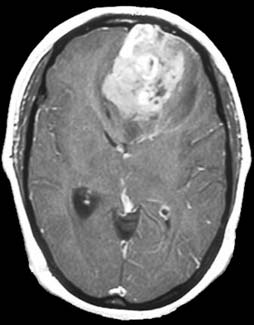

In [59]:
# Original Image
cv2_imshow(img3)

In [60]:
# %pip install sewar
# from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp
# rmse(img3,img_output)

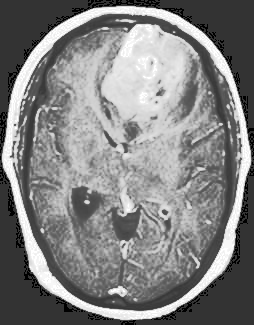

35.59487458365562
17.930520737220004
23.493349485160508
0.39545887502687427
0.6671566940065435


In [61]:
# # Applying Histogram equalization
check = IE(img3)
img_output = check.HE()
cv2_imshow(img_output)
q = Quantitation()
print(q.MSE(img3,img_output))
print(q.PSNR(img3,img_output))
print(q.AMBE(img3,img_output))
print(q.SNR(img3,img_output))
print(q.SSIM(img3,img_output))

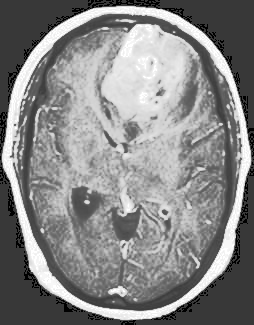

35.819792639020314
17.02554790407485
28.229606299212605
0.3591041909138431
0.6728197096038926


In [62]:
# # Applying BBHE
check = IE(img3)
img_output = check.BBHE()
cv2_imshow(img_output)
q = Quantitation()
print(q.MSE(img3,img_output))
print(q.PSNR(img3,img_output))
print(q.AMBE(img3,img_output))
print(q.SNR(img3,img_output))
print(q.SSIM(img3,img_output))

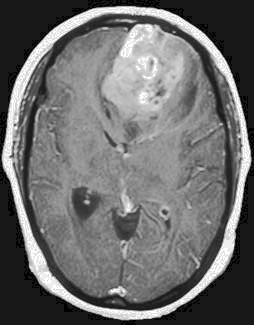

34.12313871605646
25.16323591260671
2.8467474258025476
0.41055641251276076
0.8074001364493958


In [63]:
# # Applying RMSHE
check = IE(img3)
img_output = check.RMSHE()
cv2_imshow(img_output)
q = Quantitation()
print(q.MSE(img3,img_output))
print(q.PSNR(img3,img_output))
print(q.AMBE(img3,img_output))
print(q.SNR(img3,img_output))
print(q.SSIM(img3,img_output))

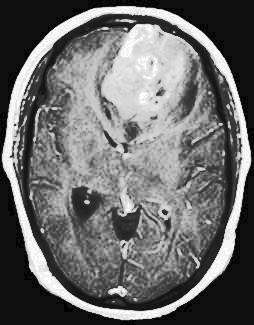

34.860963075258255
21.231665010016275
1.8035251362810527
0.471335111887067
0.6644961815873941


In [64]:
# # Applying MMBEBHE
check = IE(img3)
img_output = check.MMBEBHE()
cv2_imshow(img_output)
q = Quantitation()
print(q.MSE(img3,img_output))
print(q.PSNR(img3,img_output))
print(q.AMBE(img3,img_output))
print(q.SNR(img3,img_output))
print(q.SSIM(img3,img_output))

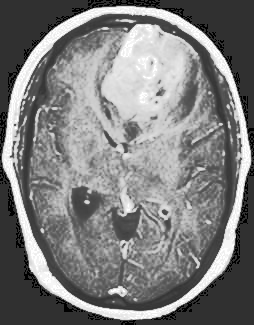

35.40830400704375
18.71759129879929
19.237758933979407
0.4353240593479313
0.6679875819626311


In [65]:
# # Applying DSIHE
check = IE(img3)
img_output = check.DSIHE()
cv2_imshow(img_output)
q = Quantitation()
print(q.MSE(img3,img_output))
print(q.PSNR(img3,img_output))
print(q.AMBE(img3,img_output))
print(q.SNR(img3,img_output))
print(q.SSIM(img3,img_output))

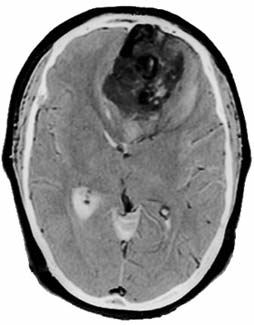

42.118751530827794
3.992134895261335
42.90793458509995
1.2733885085018672
-0.33702458405084085


In [66]:
# # Applying Image Invert/Complement
im = np.array(img3)
mask = np.full(im.shape,255)
mod_img = mask - im
img_output = mod_img.astype(np.uint8)
cv2_imshow(img_output)
q = Quantitation()
print(q.MSE(img3,img_output))
print(q.PSNR(img3,img_output))
print(q.AMBE(img3,img_output))
print(q.SNR(img3,img_output))
print(q.SSIM(img3,img_output))

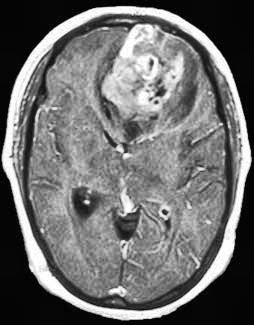

34.38875372583853
23.67036682192223
3.54551181102363
0.35768726140219576
0.797890195539049


In [67]:
# # Applying CLAHE
# Taking Input Image
input_image = cv2.imread('/content/Y13.jpg', 0)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
R, G, B = cv2.split(input_image)
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8, 8))
output2_R = clahe.apply(R)
output2_G = clahe.apply(G)
output2_B = clahe.apply(B)
img_output = cv2.merge((output2_R, output2_G, output2_B))
cv2_imshow(img_output)
q = Quantitation()
print(q.MSE(input_image,img_output))
print(q.PSNR(input_image,img_output))
print(q.AMBE(input_image,img_output))
print(q.SNR(input_image,img_output))
print(q.SSIM(input_image,img_output))

In [68]:
# #Gamma Correction
def gammaCorrection(src, gamma):
    invGamma = 1 / gamma
    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)
    return cv2.LUT(src, table)

Gamma Correction


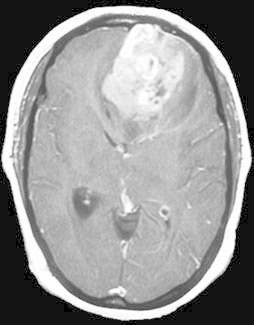

36.51817693686324
14.496483554068085
41.973846153846154
0.2543667084835765
0.7329763127766982


In [69]:
# Taking Input Image
img = cv2.imread('/content/Y13.jpg')
gammaImg = gammaCorrection(img, 2.2)
# print('Original Image')
# cv2_imshow(img)
print('Gamma Correction')
cv2_imshow(gammaImg)
q = Quantitation()
print(q.MSE(img,gammaImg))
print(q.PSNR(img,gammaImg))
print(q.AMBE(img,gammaImg))
print(q.SNR(img,gammaImg))
print(q.SSIM(img,gammaImg))

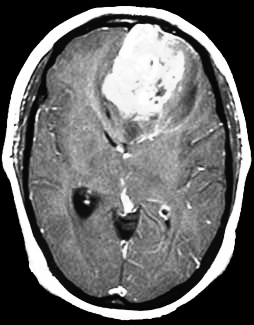

In [70]:
# # Applying Contrast Stretching
img = cv2.imread('/content/Y13.jpg',0)
original = img.copy()
xp = [0, 64, 128, 192, 255]
fp = [0, 16, 128, 240, 255]
x = np.arange(256)
table = np.interp(x, xp, fp).astype('uint8')
img = cv2.LUT(img, table)
# cv2_imshow(original)
cv2_imshow(img)

In [71]:
q = Quantitation()
print(q.MSE(original,img))
print(q.PSNR(original,img))
print(q.AMBE(original,img))
print(q.SNR(original,img))
print(q.SSIM(original,img))

34.43086352694294
23.441964729445168
1.855324046032706
0.7162455450486893
0.851226390056563
